# How to solve this task with cellular automata ?

In [8]:
# from ca_utils import display_vid, plot_task, load_data

import 에러로 직접 import

In [9]:
import numpy as np

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image, ImageDraw


import os

try:
    import moviepy
except:
    print('installing moviepy')
    os.system('pip install moviepy')

from moviepy.editor import ImageSequenceClip


from pathlib import Path
    
data_path = Path('/kaggle/input/abstraction-and-reasoning-challenge/')


cmap_lookup = [
        '#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
        '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'
]
cmap_lookup = [ np.array( [int(x[1:3],16), int(x[3:5],16), int(x[5:],16)])  for x in cmap_lookup]


def cmap(x):
    """ 
        Translate a task matrix to a color coded version
        
        arguments
            x : a h x w task matrix
        returns 
            a h x w x 3 matrix with colors instead of numbers
    """
    y = np.zeros((*x.shape, 3))
    y[x<0, :] = np.array([112,128,144])
    y[x>9,:] = np.array([255,248,220])
    for i, c in enumerate(cmap_lookup):        
        y[x==i,:] = c
    return y
    
def draw_one(x, k=20):
    """
        Create a PIL image from a task matrix, the task will be 
        drawn using the default color coding with grid lines
        
        arguments
            x : a task matrix
            k = 20 : an up scaling factor
        returns
            a PIL image 
            
    """
    img = Image.fromarray(cmap(x).astype(np.uint8)).resize((x.shape[1]*k, x.shape[0]*k), Image.NEAREST )
    
    draw = ImageDraw.Draw(img)
    for i in range(x.shape[0]):
        draw.line((0, i*k, img.width, i*k), fill=(80, 80, 80), width=1)   
    for j in range(x.shape[1]):    
        draw.line((j*k, 0, j*k, img.height), fill=(80, 80, 80), width=1)
    return img


def vcat_imgs(imgs, border=10):
    """
        Concatenate images vertically
        
        arguments:
            imgs : an array of PIL images
            border = 10 : the size of space between images
        returns:
            a PIL image
    """
    
    h = max(img.height for img in imgs)
    w = sum(img.width for img in imgs)
    res_img = Image.new('RGB', (w + border*(len(imgs)-1), h), color=(255, 255, 255))

    offset = 0
    for img in imgs:
        res_img.paste(img, (offset,0))
        offset += img.width + border
        
    return res_img




def plot_task(task):
    """
        Plot a task
        
        arguments:
            task : either a task read with `load_data` or a task name
    """
    
    if isinstance(task, str):
        task_path = next( data_path / p /task for p in ('training', 'evaluation','test') if (data_path / p / task).exists() )
        task = load_data(task_path)
    n = len(task["train"]) + len(task["test"])
    fig, axs = plt.subplots(2, n, figsize=(n*4, 8))
    plt.subplots_adjust(wspace=0, hspace=0)
    fig_num = 0
    
    def go(ax, title, x):
        ax.imshow(draw_one(x), interpolation='nearest')
        ax.set_title(title)
        ax.set_yticks([])
        ax.set_xticks([])
        
    for i, t in enumerate(task["train"]):
        go(axs[0][fig_num], f'Train-{i} in', t["input"])
        go(axs[1][fig_num], f'Train-{i} out', t["output"])
        fig_num += 1
    for i, t in enumerate(task["test"]):
        go(axs[0][fig_num], f'Test-{i} in', t["input"])
        go(axs[1][fig_num], f'Test-{i} out', t["output"])
        fig_num += 1
    
    plt.tight_layout()
    plt.show()
    
    
    
def trace_automata(step_fn, input, n_iter, n_hidden, loadbar=True):
    """
        Execute an automata and return all the intermediate states
        
        arguments:
            step_fn : transition rule function, should take two arguments `input` and `hidden_i`, 
                should return an output grid an a new hidden hidden grid
            n_iter : num of iteration to perform
            n_hidden: number of hidden grids, if set to 0 `hidden_i` will be set to None
            laodbar = True: weather display loadbars
        returns:
            an array of tuples if output and hidden grids
    """
    
    hidden = np.zeros((n_hidden, *input.shape)) if n_hidden > 0 else None
    
    trace = [(input, hidden)]
    
    its = range(n_iter)
    if loadbar:
        its = tqdm(its, desc='Step')
    for _ in its:
        output, hidden = step_fn(input, hidden)
        trace.append((output, hidden))        
        input = output
    return trace


def vis_automata_trace(states, loadbar=True, prefix_image=None): 
    """
        Create a video from an array of automata states
        
        arguments:
            states : array of automata steps, returned by `trace_automata()`
            loadbar = True: weather display loadbars
            prefix_image = None: image to add to the beginning of each frame 
        returns 
            a moviepy ImageSequenceClip
    """
    frames = []
    if loadbar:
        states = tqdm(states, desc='Frame')
    for i, (canvas, hidden) in enumerate(states):
        
        frame = []
        if prefix_image is not None:
            frame.append(prefix_image)
        frame.append(draw_one(canvas))
        if hidden is not None:
            frame.extend(draw_one(h) for h in hidden)
        frames.append(vcat_imgs(frame))            
        
    return ImageSequenceClip(list(map(np.array, frames)), fps=10)


from moviepy.editor import clips_array, CompositeVideoClip


from moviepy.video.io.html_tools import html_embed, HTML2

def display_vid(vid, verbose = False, **html_kw):
    """
        Display a moviepy video clip, useful for removing loadbars 
    """
    
    rd_kwargs = { 
        'fps' : 10, 'verbose' : verbose 
    }
    
    if not verbose:
         rd_kwargs['logger'] = None
    
    return HTML2(html_embed(vid, filetype=None, maxduration=60,
                center=True, rd_kwargs=rd_kwargs, **html_kw))


def vis_automata_task(tasks, step_fn, n_iter, n_hidden, vis_only_ix=None):
    """
        Visualize the automata steps during the task solution
        arguments:
            tasks : the task to be solved by the automata
            step_fn : automata transition function as passed to `trace_automata()`
            n_iter : number of iterations to perform
            n_hidden : number of hidden girds
    """
    
    n_vis = 0        
    
    def go(task, n_vis):
        
        if vis_only_ix is not None and vis_only_ix != n_vis:
            return 
        
        trace = trace_automata(step_fn, task['input'], n_iter, n_hidden, loadbar=False)
        vid = vis_automata_trace(trace, loadbar=False, prefix_image=draw_one(task['output']))
        display(display_vid(vid))
        
    
        
    for task in (tasks['train']):
        n_vis += 1
        go(task, n_vis)
        
    for task in (tasks['test']):
        n_vis += 1
        go(task, n_vis)
    
    
#
# Data IO
#

import os
import json

training_path = data_path / 'training'
evaluation_path = data_path / 'evaluation'
test_path = data_path / 'test'

training_tasks = sorted(os.listdir(training_path))
evaluation_tasks = sorted(os.listdir(evaluation_path))
test_tasks = sorted(os.listdir(test_path))

def load_data(p, phase=None):
    """
        Load task data
        
    """
    if phase in {'training', 'test', 'evaluation'}:
        p = data_path / phase / p
    
    task = json.loads(Path(p).read_text())
    dict_vals_to_np = lambda x: { k : np.array(v) for k, v in x.items() }
    assert set(task) == {'test', 'train'}
    res = dict(test=[], train=[])
    for t in task['train']:
        assert set(t) == {'input', 'output'}
        res['train'].append(dict_vals_to_np(t))
    for t in task['test']:
        assert set(t) == {'input', 'output'}
        res['test'].append(dict_vals_to_np(t))
        
    return res

installing moviepy


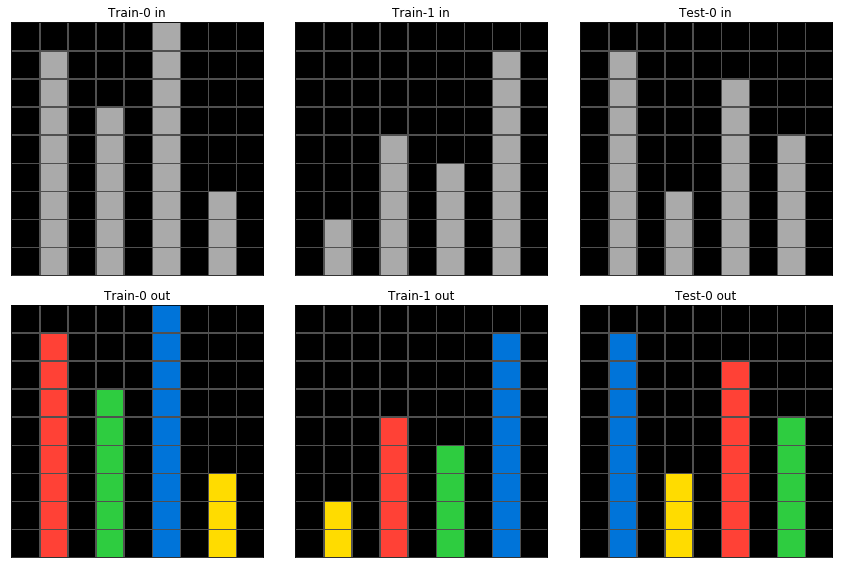

In [10]:
task = load_data('08ed6ac7.json', phase='training')
plot_task(task)

여기에 그들의 크기의 순서에 따라 막대가 색칠된 cellular automata의 비디오가 있다. 만약 여러분이 이것이 어떻게 작동되는 지 이해하고 싶다면 읽어라!

<!--
Here is a video of a cellular automata coloring the bars in order of their size. If you want to understand how this works read on ! 
-->

In [11]:
from moviepy.editor import VideoFileClip

display_vid(VideoFileClip('../input/ca-videos/IaANIHh6.mp4'), loop=True, autoplay=True)

# 0. Introduction
먼저 저는 캐글 competition의 설립자에게 고맙다고 하고 싶다. 이 경쟁은 꽤 특이하고 저는 공통적인 방법은 실패할 것이라는 것을 믿는다. 저에게는 이 도전에 "out of the box"에 적용시킬 것이라는 표준적인 머신러닝 방법에서 방법을 생각하는 것이 어렵다. 그리고 이것은 꽤 흥미롭다!

<!--
First of all I want to thank the organizers of this  kaggle competition. This competition is quite unorthodox 
and I believe common methods, will fail to work. For me it is hard to think of a tool from the standard machine
learning toolbox that will be applicable "out of the box" to this challenge and this is quite exciting! 
-->

매일 추론을 할 수 있는 알고리즘을 생성하기 위해 도전하는 것은 아니다. 

<!--
Not every day you are challenged to create an algorithm capable of reasoning!
-->

저는 이 도전이 해결될 수 있고, 성공적인 솔루션의 일부가 수리과학의 약간 사소한 영역인 cellular automata 이라고 믿습니다. 이 노트북에서 저는 celluar automata (CA)가 이 도전을 처리하기 위해 어떻게 사용될 수 있는 지 설명할 것입니다.

<!--
I believe this challenge could be solved and part of a successful solution are cellular automata, a somewhat niche area of mathematical science.
In this notebook I will try to explain how cellular automata (CA) could be used to tackle this challenge.
-->

_part 1_ 에서 저는 CA가 무엇인지, 사람들이 그것에 흥미가 있는 이유와 어떤 형태로 매우 작은 규칙이 매우 복잡한 시스템이 나오는 지를 설명할 것 입니다. 그리고 _part 2_ 에서 저는 이 도전에 CA가 어떻게 연결되는 지를 설명할 것입니다. 더 정확히는 CA가 합당한 규칙을 생성하기 위한 완벽한 매체로서 어떻게 사용될 수 있는 지에 대한 것입니다. 저는 공식적으로 무엇이 CA인 지 정의할 것이고, _part 3_ 에선 저는 정의된 CA를 위한 전이 규칙을 구현함으로써 몇몇의 작업을 해결할 것입니다. _part4와 part5_ 에서 저는 작업 솔루션을 분석하고, 흥미로운 패턴을 찾고, 이 도전에서 얼마나 성공적인 솔루션인지를 주장할 것입니다.

<!--
In  _part 1_ I will briefly describe what are CA, why people are interested in them and how form very few rules extremely complex systems emerge. Then 
in _part 2_ I will describe how CA are connected to this challenge. More precisely how CA could be 
used as a perfect medium for deriving reasoning rules. I will formally define what a CA is and in _part 3_ I will solve several tasks by implementing transition rules for the defined CA. In _part 4 and 5_ I will analyze the task solutions, find interesting patterns and argue how a successful solution to this challenge would look like.
-->


저는 또한 작업을 완료하기 위한 CA 솔루션을 공유하기 위해 이 [thread](https://www.kaggle.com/c/abstraction-and-reasoning-challenge/discussion/131196) 를 만들었습니다. 당신의 참여를 환영합니다!

<!--
I have also created a [thread](https://www.kaggle.com/c/abstraction-and-reasoning-challenge/discussion/131196) to share CA solutions to complex tasks, you are welocmed to participate !
-->


# 1. What are Cellular Automata (CA)

[Wikipedia](https://en.wikipedia.org/wiki/Cellular_automaton) 는 CA가 무엇인지 설명하기 위한 훌륭한 사이트입니다:

<!--
[Wikipedia](https://en.wikipedia.org/wiki/Cellular_automaton) does a great job in describing what CA is:
-->

> **cellular automaton**은 on이나 off 같은 유한한 수의 상태 중 하나로 된 규칙적인 셀의 그리드로 구성됩니다. 이 그리드는 유한한 수의 차원에 있을 수 있습니다. 각 셀에는 명시괸 셀과 연관되어있는 이웃이라고 하는 셀들의 집합이 정의됩니다. 초기 상태 (time t = 0)는 각 셀에 상태를 할당하면서 선택됩니다. 새로운 세대는 몇몇의 정해진 룰을 따라 (t가 1 지나면서) 생성됩니다. 이 룰은 현재 셀들의 상태와 이웃에 있는 셀들의 상태에서 각각의 셀의 새로운 상태를 결정하는 방식입니다. 전형적으로, 셀의 상태를 바꾸기 위한 룰은 각각의 셀에 같고, 시간에 따라 변하지 않습니다. 그리고 전체 그리드에 대해 동시에 적용됩니다.

<!--
> A **cellular automaton** consists of a regular grid of cells, each in one of a finite number of states [...], such as on and off. The grid can be in any finite number of dimensions. For each cell, a set of cells called its neighborhood is defined relative to the specified cell. An initial state (time t = 0) is selected by assigning a state for each cell. A new generation is created (advancing t by 1), according to some fixed rule [...] that determines the new state of each cell in terms of the current state of the cell and the states of the cells in its neighborhood. Typically, the rule for updating the state of cells is the same for each cell and does not change over time, and is applied to the whole grid simultaneously.
-->

다시 말해서, CA는 그리드에 있는 숫자들의 집합을 바꾸는 방식을 설명하는 전이 규칙의 모음입니다.

<!--
In other words CA is a collection of transition rules which specify how to update a set of numbers situated on a grid.
-->

CA는 흥미롭습니다. 왜냐하면 꽤 복잡한 행동이 단순한 방식으로 나타나기 때문입니다. 그런 방식의 괜찮은 예는 [Game of Life](https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life) (GoL) 입니다. 고전적인 공식인 GoL에선, 두 개의 상태 (0 죽음, 1 생존)을 가지는 셀들의 무한한 그리드를 사용하여 구현됩니다.

<!--
CA are interesting because quite complex behaviours emerge form rather simple rules. 
A great example of such emergence is the, [Game of Life](https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life) (GoL). 
In it's classical formulation GoL is implemented using an infinite grid with cells having two states - 0 dead, 1 alive.
-->

4개의 전이 규칙이 있습니다.

<!--
There are four transition rules:
-->

1. 마치 인구 과소처럼, 두 개 보다 적은 살아있는 이웃이 있는 어떤 살아있는 셀은 죽는다.
2. 두개나 세개의 살아 있는 이웃이 있는 어떤 살아있는 셀은 다음 세대에 산다.
3. 마치 인구 과잉처럼, 3개 보다 많은 이웃의 어떤 살아 있는 셀은 죽는다.
4. 마치 재생성처럼, 정확히 3개의 살아 있는 이웃이 있는 어떤 죽은 셀은 살아있는 셀이 된다.

<!--
1. Any live cell with fewer than two live neighbours dies, as if by underpopulation.
2. Any live cell with two or three live neighbours lives on to the next generation.
3. Any live cell with more than three live neighbours dies, as if by overpopulation.
4. Any dead cell with exactly three live neighbours becomes a live cell, as if by reproduction.
-->

이런 겉보기에 단순한 규칙들은 꽤 흥미로운 현상의 발생시킨다.

<!--
These seemingly simple rules give rise to quite interesting phenomena.
-->

- **[osicllators](https://en.wikipedia.org/wiki/Oscillator_(cellular_automaton%29)** - 하나의 상태에서 다른 상태로 무한정 진동하는 패턴

<!--
- **[osicllators](https://en.wikipedia.org/wiki/Oscillator_(cellular_automaton%29)** - patterns which oscillate from one state to the other indefinitely.
-->

<table>
    <tr>
        <th> Pulsar</th>
        <th> Kok's galaxy</th>
        <th> pentadecathlon </th>
    </tr>
    <tr>
        <td><img src="https://upload.wikimedia.org/wikipedia/commons/0/07/Game_of_life_pulsar.gif"></img></td>
        <td><img src="https://upload.wikimedia.org/wikipedia/commons/2/2a/Oscilador8periodos.gif"></img></td>
        <td><img src="https://upload.wikimedia.org/wikipedia/commons/f/fb/I-Column.gif"></img> </td>
    </tr>
</table>

- **[spaseships](https://en.wikipedia.org/wiki/Spaceship_(cellular_automaton%29)** - 그리드를 따라 움직이는 패턴

<!--
- **[spaseships](https://en.wikipedia.org/wiki/Spaceship_(cellular_automaton%29)** - patterns which move across the grid.
-->

<table>
    <tr>
        <th> Glider</th>
        <th> Middle-weight spaceship </th>
        <th> Heavy-weight spaceship </th>
    </tr>
    <tr>
        <td><img src="https://upload.wikimedia.org/wikipedia/commons/f/f2/Game_of_life_animated_glider.gif"></img></td>
        <td><img src="https://upload.wikimedia.org/wikipedia/commons/4/4e/Animated_Mwss.gif"></img></td>
        <td><img src="https://upload.wikimedia.org/wikipedia/commons/4/4f/Animated_Hwss.gif"></img></td>
    </tr>
</table>

더 복잡한 행동이 생성될 수도 있습니다.

<!--
More complex behaviors could be created: 
-->

 - 다른 패턴으로 생산할 수 있는 패턴들입니다. 예를 들어 글라이더를 생성하는 총입니다.
 ![](https://upload.wikimedia.org/wikipedia/commons/e/e5/Gospers_glider_gun.gif)
 - 미리 정해진 방식으로 다른 패턴들과 상호작용하는 패턴입니다. 예를 들어, [reflectors](https://en.wikipedia.org/wiki/Reflector_(cellular_automaton%29) (아래 그림에서 분홍색) 글라이더가 반영됩니다.
 ![](https://upload.wikimedia.org/wikipedia/commons/d/d0/Color_coded_racetrack_large_channel.gif)


<!--
 - Patterns that are able to produce other patterns. For example guns which produce gliders.
 ![](https://upload.wikimedia.org/wikipedia/commons/e/e5/Gospers_glider_gun.gif)
 - Patterns that interact with other patterns in a prefefined way. For example [reflectors](https://en.wikipedia.org/wiki/Reflector_(cellular_automaton%29) (the pink ones in the picture below) reflect gliders.
 ![](https://upload.wikimedia.org/wikipedia/commons/d/d0/Color_coded_racetrack_large_channel.gif)
 -->

- 안정화를 위해 많은 세대를 가지는 패턴입니다. 예를 들어 the [switch engine](https://www.conwaylife.com/wiki/Switch_engine) - 8개의 셀로 구성된 패턴은 오직 3911 반복 후에 842개의 셀로 된 패턴으로 안정화됩니다.

<!--
 - Patters which take a large number of generations to stabilize. For example the [switch engine](https://www.conwaylife.com/wiki/Switch_engine) - a pattern composed of 8 cells stabilizes only after 3911 iterations becomes a pattern of 842 cells.
-->

 <table>
    <tr>
        <th> Switch engine it=0</th>
        <th> Switch engine it=3911</th>
    </tr>
    <tr>       
        <td><img src="https://i.ibb.co/Ydg4nKS/Cropper-Screenshot-2020-02-17-12-20-34.png"></img></td>
        <td><img src="https://www.conwaylife.com/w/images/a/af/Switchengine_final.png"></img></td>
    </tr>
</table>
 
 

 
패턴들은 더 복잡한 패턴들을 구성하기 위해 서로 조합될 수 있습니다. 예를 들어 [Noas ark](https://www.conwaylife.com/wiki/Noah%27s_ark) spaceship은 두 개의 스위치 엔진의 조합으로 생성됩니다. 제가 발견한 가장 인상적인 구성은 전체 [comuter](https://codegolf.stackexchange.com/questions/11880/build-a-working-game-of-tetris-in-conways-game-of-life) 입니다. 시스템은 테트리스를 하도록 디자인되어 있었습니다. 그러나 테트리스 게임은 하드 코딩되어 있지 않습니다. 게임은 더 상위 레벨의 언어로 쓰여있습니다. 그리고 컴파일된 뒤 컴퓨터 ROM에서 불러집니다. 컴퓨터 구조는 아래 그림에서 보여집니다.

<!--
Patterns could be combined together in order to construct more complex patterns. For example the [Noas ark](https://www.conwaylife.com/wiki/Noah%27s_ark) spaceship is created by the combination of two switch engines. The most impressive construction which I have found is a whole [comuter](https://codegolf.stackexchange.com/questions/11880/build-a-working-game-of-tetris-in-conways-game-of-life). The system was designed to play tetris, but the tetris game is not hard coded. The the game is written in a higher level language and then compiled and loaded to the computer ROM. The computer architecture is shown in the picture below.
-->

![](https://i.stack.imgur.com/JXmnf.png)

다시 저는 강조하고 싶습니다. - **오직 4개의 규칙을 기반으로 한 시스템에서 위에서 보여진 모든 현상입니다!**

<!--
Again I want to emphasize - **all shown above emerge from a system based on only 4 rules!**
-->

# 2. How are CA connected to this competition
리마인드: 이 competition에서 여러분은 한쌍의 소스 기반의 훈련 이미지가 주어진다. 여러분의 작업은 소스 이미지에서 타겟으로 전이하게 하는 규칙을 추론하는 것이다. 그리고 나중에 임의의 수의 이미지에 그런 룰을 적용하는 것이다. 여러분들이  추론해야하는 규칙은 몹시 다양하다. 예를 들어, 아래에서 보여지는 첫 이미지에서 여러분들은 'stripe'가 오른쪽 경계로 움직여야 한다. 반면에 두번째에선 빨간 모양으로 형성된 공백이 나와야 한다.

<!--
As a reminder: in this competition you are given pairs of source-target training images. Your task is to infer the rule which will allow to transition from source image to the target and later apply such rule to an arbitrary number of images. The rules which you should infer are extremely diverse, for example in the first image shown below you should continue the 'stripe' to the right border while in the second you should output the voids formed by the red shapes.
-->

![](https://i.ibb.co/h8bkyPV/task-1.png)

<img src="https://i.ibb.co/s5F3Fwz/task-0.png" alt="task-0" border="0">

저는 다소 근원적인 질문이 답해져야 한다고 느낍니다. - 어떻게 그런 규칙이 표현돼야 하는 지

<!--
I feel, a somewhat fundamental question should be answered - how such rules should be represented.
-->


일반적인 경우에, 이것은 [excitingly difficult problem](https://groups.csail.mit.edu/medg/ftp/psz/k-rep.html) 다. 그러나 이 competition의 경우에 저는 누군가 간단한 규칙에서 복잡한 행동을 창조하는 cellular automata를 이용하려고 할 수 있다고 생각합니다. 그리고 도전 규칙을 표현하기 위해 알고리즘에 의해 생성될 수 있는 언어로써 그것들을 사용한다.
<!--
In the general case this is an [excitingly difficult problem](https://groups.csail.mit.edu/medg/ftp/psz/k-rep.html), but in case of this competition I think that one could try to exploit the cellular automata ability of creating complex behaviors form simple rules. And use them as a language which could be created by an algorithm in order to represent the challenge tasks rules. 
-->

더 진행하기 전에, 저는 먼저 cellular automata로 제가 의미하는 것과 제가 '규칙을 표현하기 위한 언어' 라고 말할 때 의미하는 것을 정확히 정의해야 할 것입니다. 그 다음 저는 세 가지 업무를 해결하는 데 CA를 이 도전에 적용하는 법을 설명할 것입니다.

<!--
Before going further I will first define precisely what I mean by cellular automata and what I mean when I say 'language to represent rules'. Then I will illustrate 
how to apply CA to this challenge by solving three tasks.
-->

## Formulation of CA 
우리는 cellular automata 같은 생명을 사용할 것입니다.
우리의 CA는 두 개의 그리드(입력과 출력 그리드)를 가질 것입니다. CA 전이 규칙은 입력 그리드에 적용되고, 전이 규칙 출력은 출력 그리드로 쓰여집니다. 일단 이 반복이 완료되면, 출력 그리드는 입력 그리드가 됩니다.

<!--
We will use a life like cellular automata. 
Our CA will have two grids - and input and an output grid. The CA transition rules are applied to the input grid, the transition rules outputs are written to the output grid. Once the iteration is completed the output grid becomes the input grid. 
-->

우리의 전이 규칙이 갖는 입력으로:
- 'i,j' 입력 셀의 값
- 입력 그리드의 'i,j' 번째 입력 셀 주위의 이웃
- 현재 셀이 경계 근처에 있다는 것을 나타내는 깃발

<!--
As input our transition rules take:
- the value of the `i,j` input cell
- a neighborhood around the `i, j`-th input the cell in the input grid
- flags denoting weather the current cell is near a border
-->

전이 규칙이 주는 출력으로:
- 출력 그리드의 'i,j' 셀의 값

<!--
As output the transition rules give:
- the value of the `i, j` cell in the output grid
-->

CA의 반복은 안정적인 상태에 도달되지 않는 동안 수행됩니다. 예를 들어, 입력 그리드가 출력 그리드와 동일할 때가 그렇습니다. 안정적인 상태는 challenge에서 솔루션이 예측되는 것입니다.

<!--
The iterations of the CA are preformed while a stable state is not reached i.e. the input grid is equal tho the output grid. The stable state is expected to be the solution to the challenge.
-->

CA 전이 규칙은 이 도전에서 추론하기 위해 예측하는 규칙을 표혀하는 훌륭한 방식입니다. 여러분이 다소 부자연스러운 입력을 가지고 있다고 느낄 수 있지만, 나중에 저는 그것들도 다소 부자연스러운 운영의 집합으로 이용한다는 것을 보여줄 것입니다. 이것은 그것들을 "추론을 위한 언어" 가 되기 위한 완벽한 후보자로 만듭니다.

<!--
CA transition rules are a great way to represent the rules you are expected to infer in this challenge. As you can notice they have a rather constrained input, and later I will show that they also make use of a rather constrained set of operations. This makes them a perfect candidate for being the "language for reason".
-->

# 3. Solving problems with CA
처음의 일부 기능 함수

<!--
First some utility functions 
-->

In [12]:
from ca_utils import vis_automata_task
import numpy as np
from itertools import product

nbh = lambda x, i, j: { 
    (ip, jp) : x[i+ip, j+jp] 
        for ip, jp in product([1, -1, 0], repeat=2) 
            if 0 <= i+ip < x.shape[0] and 0 <= j+jp < x.shape[1]
}

ModuleNotFoundError: No module named 'ca_utils'

### What nbh() does
nbh() 함수는 다음 예제를 위해 자주 사용될 것입니다. 'nbh()'는 셀들의 이웃과 작동하기 위한 헬퍼 함수입니다.
아래 예는 3x3 그리드의 중앙 셀의 이웃을 가지면서 무엇을 하는 지에 대한 그림을 제공합니다.

<!--
The `nbh()` function will be used extensively in the following examples. `nbh()` is a helper function for working with neighborhoods of cells. 
The example below provides an illustration of what it does by taking neiborhood of the center cell of a 3x3 grid:
-->

    grid = np.arange(9).reshape((3,3))
    # array([[0, 1, 2],
    #        [3, 4, 5],
    #        [6, 7, 8]])
    nbh(grid, 1, 1) # dict: nbh_id -> nbh_value
    #{
    #    (-1, -1): 0, (-1, 0): 1, (-1, 1): 2,
    #    ( 0, -1): 3, ( 0, 0): 4, ( 0, 1): 5,
    #    (1, -1): 6,  ( 1, 0): 7, (1, 1): 8,
    #}

### Color coding

이 challenge를 통해 색깔 코딩을 선택하는 작업을 시각화하기 위해, 여기선 우리가 무슨 색이 무슨 숫자와 연결되는 지를 보여줍니다. (code taken from [here](https://www.kaggle.com/nagiss/abstraction-and-reasoning-view-all-data))

<!--
Through this challenge in order to visualize the tasks color coding are adopted, here we show what color corresponds to what number. (code taken from [here](https://www.kaggle.com/nagiss/abstraction-and-reasoning-view-all-data))
-->

In [ ]:
import matplotlib.colors as colors
import matplotlib.pyplot as plt

_cmap = colors.ListedColormap(
    ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)
# 0:black, 1:blue, 2:red, 3:greed, 4:yellow,
# 5:gray, 6:magenta, 7:orange, 8:sky, 9:brown
plt.figure(figsize=(5, 2), dpi=200)
plt.imshow([list(range(10))], cmap=_cmap, norm=norm)
plt.xticks(list(range(10)))
plt.yticks([])
plt.show()

## Task training/db3e9e38, continue the pattern
'trainig/db3e9e38' 작업을 위한 cellular automata를 디자인해봅시다.

<!--
Let's try to design a cellular automata for task `training/db3e9e38`. 
-->

In [ ]:
task = load_data('db3e9e38.json', phase='training')

plot_task(task)

일을 단순하게 하고, 먼저 패턴을 오른쪽으로 반복하기 위한 CA 전이 규칙을 작성합시다.

<!--
Let's keep things simple and first write CA transition rules for repeating the pattern to the right.
-->

    - R1: 만약 현재 셀이 색이 있다면 -> 아무 것도 하지 않는다.
    - R2: 만약 현재 셀이 검은색이고, 왼쪽 이웃과 왼쪽 아래 이웃이 주황색 셀이면 -> 연한 파란색 셀을 출력
    - R3: 만약 현재 셀이 검은색이고, 왼쪽 이웃과 왼쪽 아래 이웃이 연한 파란색이면 -> 주황색 셀을 출력

<!--
    - R1: if the current call has a color -> do nothing
    - R2: if the current cell is black and as it's left neighbor and lower left neighbors are orange cells 
        -> output a light blue cell
    - R3: if the current cell is black and as it's left neighbor and lower left neighbors are light blue cells 
        -> output an orange cell 
-->

우리는 이웃 전이 규칙을 다음처럼 시각화할 수 있습니다.

<!--
We can visualize the neighborhood transition rules as:
-->

    light blue  *   *
    light blue      *   -> orange
      *         *   * 
      
    orange  *   *
    orange      *   -> light blue
      *     *   *                 * - means  cell of any color

구현해 봅시다.

<!--
Let's try to implement it:
-->

In [ ]:

def compute_db3e9e38_part_automata_step(input, hidden_i):
    #
    # this function takes as input the input grid and outputs the output grid

    # input, is the input grid
    # ignore hidden_i for now
    
    # for convenience let's name the colors
    blk, blu, red, grn, ylw, gry, pur, orn, azu, brw = range(10)
    
    # let's create the output grid
    output = np.zeros_like(input, dtype=int)
    
    # here we iterate over all the coordinates of cells in the input grid
    for i, j in product(range(input.shape[0]), range(input.shape[1])):
        # current cell and current neighborhood 
        i_c = input[i, j]                
        i_nbh = nbh(input, i, j)
        
        # Here our transition rule starts 
        # R1: if the current call has color
        if i_c != blk:
            output[i, j] = i_c # leave it there 
            
        # R2: if the current cell is black and as it's left neighbor and lower left neighbors are orange cells 
        elif i_c == blk and i_nbh.get((0, -1)) == orn and i_nbh.get((1, -1)) == orn:
            output[i, j] = azu # paint it in light blue (azure)
        
        # R3: if the current cell is black and as it's left neighbor and lower left neighbors are light blue cells  
        elif i_c == blk and i_nbh.get((0, -1)) == azu and i_nbh.get((1, -1)) == azu:
            output[i, j] = orn # paint it in orange
        
    return output, hidden_i
            
vis_automata_task(task, compute_db3e9e38_part_automata_step, 16, 0)

그래서, 우리가 작업을 해결한 오직 세 개의 규칙으로, 이전 규칙의 대칭적인 변화를 추가합시다.

<!--
So, with only three rules we nearly solved the task, let's add symmetrical variants of the previous rules.
-->

In [ ]:
def compute_db3e9e38_automata_step(input, hidden_i):
    # ignore hidden_i for now
    blk, blu, red, grn, ylw, gry, pur, orn, azu, brw = range(10)
    
    output = np.zeros_like(input, dtype=int)
    
    for i, j in product(range(input.shape[0]), range(input.shape[1])):
        i_c = input[i, j]                
        i_nbh = nbh(input, i, j)
        
        # R1
        if i_c != blk:
            output[i, j] = i_c
            
        # R2 and it's symmetrical variant
        if i_c == blk and i_nbh.get((0, 1)) == orn and i_nbh.get((1, 1)) == orn:
            output[i, j] = azu
        elif i_c == blk and i_nbh.get((0, -1)) == orn and i_nbh.get((1, -1)) == orn:
            output[i, j] = azu
        
        # R3 and it's symmetrical variant
        elif i_nbh.get((0, 1)) == azu and i_nbh.get((1, 1)) == azu:
            output[i, j] = orn
        elif i_nbh.get((0, -1)) == azu and i_nbh.get((1, -1)) == azu:
            output[i, j] = orn
        
    return output, hidden_i
            
        

vis_automata_task(task, compute_db3e9e38_automata_step, 16, 0)

오직 5개의 전이 규칙으로 해결됐다!
다른 것을 해봅시다!

<!--
Solved with only 5 transition rules ! 
Let's do another one!
-->

## Task training/b27ca6d3, circle two red cells
이 작업은 약간 더 어렵습니다: 우리는 돈 연속적인 쌍의 빨간 셀을 초록색으로 동그라미쳐야합니다. 제가 말하는 연속적인 셀은 같은 선을 공유하는 것입니다.

<!--
This task is a little bit harder: we need to circle with green cells all the consecutive pairs of red cells. By consecutive cells I mean cells which share a common edge.
-->

In [ ]:
task = load_data('b27ca6d3.json', phase='training')

plot_task(task)

규칙을 정하고 구현합시다. 지금부터 우리는 경계 근처의 셀을 무시할 것입니다.

<!--
Let's sketch the rules and implement them, for now we will ignore the cells near the borders:
-->

    - R0 만약 검은색이 아니면 -> 아무것도 하지 않는다.
    - R1 만약 이웃이 두 개의 연속적인 빨간 셀을 포함한다면 -> 셀을 초록색으로 칠한다.
    - R2 만약 이웃이 초록, 빨강, 초록으로 된 세 개의 연속적인 셀을 포함한다면 -> 셀을 초록색으로 칠한다.
    - R3 만약 이웃이 한 구석에 위치한 초록, 빨강, 초록으로 된 세 개의 연속적인 셀을 포함한다면 -> 셀을 초록색으로 칠한다.

<!--
      - R0 if not black -> do nothing
      - R1 if the neighborhood contains two consecutive red cells 
          -> color the cell with green
      - R2 if the neighborhood contains three consecutive cells colored green, red, green 
          -> color the cell with green
      - R3 if the neighborhood contains three consecutive cells colored green, red, green arranged in a corner
          -> color the cell with green
-->

In [ ]:
def compute_b27ca6d3_part3_automata_step(input, hidden_i):
    # ignore hidden_i for now
    blk, blu, red, grn, ylw, gry, pur, orn, azu, brw = range(10)
    
    output = np.zeros_like(input, dtype=int)
    
    for i, j in product(range(input.shape[0]), range(input.shape[1])):
        i_c = input[i, j]       
        i_nbh = nbh(input, i, j)
        
        is_top_b, is_bottom_b = i == 0, i == input.shape[0]-1
        is_left_b, is_right_b = j == 0, j == input.shape[1]-1
        is_b = is_top_b or is_bottom_b or is_left_b or is_right_b
        
        # clock wise orderd neighboring elements
        cw_nbh_ixs = [ (-1, -1), (-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1)]

        # consecutive cell pairs
        pair_ixs = list(zip(cw_nbh_ixs[:-1], cw_nbh_ixs[1:])) + [(cw_nbh_ixs[-1],cw_nbh_ixs[0])]
                    
        # sides of the rectangle formed by the neighboring cells
        side_ixs = [ 
            cw_nbh_ixs[:3], # top
            cw_nbh_ixs[2:5], # left
            cw_nbh_ixs[4:7], # bottom 
            cw_nbh_ixs[6:] + cw_nbh_ixs[:1] # right
        ]        
        
        # tests if all the cells are non border ones
        all_present = lambda s1, c, s2: all(x in i_nbh for x in [s1, c, s2])
        # tests if the three cells are colored green, red, green
        test_side = lambda s1, c, s2: (i_nbh.get(s1, grn),i_nbh.get(c, red),i_nbh.get(s2, grn)) == (grn, red, grn)
        
        # corners of the square formed by the neighboring pixels
        corner_ixs = [ 
            cw_nbh_ixs[1:4], # top right
            cw_nbh_ixs[3:6], # bottom right
            cw_nbh_ixs[5:8], # bottom left
            cw_nbh_ixs[7:] + cw_nbh_ixs[:2] # top left
        ]
        
        # R0 if cell has color 
        if i_c != blk:
            output[i, j] = i_c # do nothing 
               
        # R1: if the neighborhood contains two consecutive red cells 
        elif any(i_nbh.get(ix1) == red and i_nbh.get(ix2) == red for ix1, ix2 in pair_ixs):
            output[i, j] = grn   # color in green
            
        # R2: if the neighborhood contains three consecutive cells colored with green red green 
        elif any( test_side(s1, c, s2) for s1, c, s2 in side_ixs if all_present( s1, c, s2)):
            output[i, j] = grn # color in green 
        
        # R3: if the neighborhood contains three consecutive cells colored with green red green arranged in a corner
        elif  any( test_side(s1, c, s2) for s1, c, s2 in corner_ixs if all_present(s1, c, s2)):
            output[i, j] = grn 
        
        
    return output, hidden_i

vis_automata_task(task, compute_b27ca6d3_part3_automata_step, 5, 0)

이제 우리는 코너의 케이스를 다룰 필요가 있다. - 셀은 가까운 경계일 때, 그것을 위한 규칙을 추가하자.

    - R1 만약 이웃이 두 개의 연속적인 빨간 셀이 포함한다면 -> 셀을 초록색으로 칠한다.
    - R2 만약 이웃이 직선 코너에 위치한 초록, 빨강, 초록의 연속적인 셀을 포함한다면 -> 색을 초록색으로 칠한다.
    - R3 만약 이웃이 코너에 초록, 빨강, 초록의 연속적인 셀을 포함한다면 -> 초록색으로 칠한다.
    - R4 만약 우리가 경계 근처에 있고, 하나의 초록색과 하나의 빨간색의 연속적인 셀이 위치한다면 -> 초록색으로 칠한다.

<!--
Now we just need to deal with the corner case - when cells are near a border. Let's add a rule for that. 

      - R1 if the neighborhood contains two consecutive red cells 
          -> color the cell with green
      - R2 if the neighborhood contains three consecutive cells colored with green red green arranged in straight line corner
          -> color the cell with green
      - R3 if the neighborhood contains three consecutive cells colored with green red green arranged in a corner
          -> color the cell with green
      - R4 if we are near a border and one green and one red consecutive cells are present
          -> color the cell with green
-->

코드가 같은 상태로 있고, 우리는 헬퍼 함수를 정의하고 if 블롯 끝에 'R4'를 추가한다.

<!--
The code stays the same, we just define a helper function and add `R4` to the end of the if block.
-->

```python

# ....

# tests if the center cell is present with least one cell present on the side
some_present = lambda s1, c, s2: c in i_nbh and (s1 in i_nbh or s2 in i_nbh)

# ...

# R4: if we are near a border and one green and one red consecutive cells are present
elif i_c == blk and is_b and any( test_side(s1, c, s2) 
                                     for s1, c, s2 in side_ixs 
                                         if some_present( s1, c, s2) ):
    output[i, j] = grn 

```

In [ ]:
def compute_b27ca6d3_automata_step(input, hidden_i):
    
    blk, blu, red, grn, ylw, gry, pur, orn, azu, brw = range(10)
    
    output = np.zeros_like(input, dtype=int)
    
    for i, j in product(range(input.shape[0]), range(input.shape[1])):
        i_c = input[i, j]       
        i_nbh = nbh(input, i, j)
        
        is_top_b, is_bottom_b = i == 0, i == input.shape[0]-1
        is_left_b, is_right_b = j == 0, j == input.shape[1]-1
        is_b = is_top_b or is_bottom_b or is_left_b or is_right_b
        
        # clock wise orderd neiborhood elements
        cw_nbh_ixs = [ (-1, -1), (-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1)]

        # consecutive cell pairs
        pair_ixs = list(zip(cw_nbh_ixs[:-1], cw_nbh_ixs[1:])) + [(cw_nbh_ixs[-1],cw_nbh_ixs[0])]
                    
        # sides of the rectangle formed by the neighboring cells
        side_ixs = [ 
            cw_nbh_ixs[:3], # top
            cw_nbh_ixs[2:5], # left
            cw_nbh_ixs[4:7], # bottom 
            cw_nbh_ixs[6:] + cw_nbh_ixs[:1] # right
        ]        
        
        # tests if all the cells are non border ones
        all_present = lambda s1, c, s2: all(x in i_nbh for x in [s1, c, s2])
        # tests if the three cells are colored green, red, green
        test_side = lambda s1, c, s2: (i_nbh.get(s1, grn),i_nbh.get(c, red),i_nbh.get(s2, grn)) == (grn, red, grn)
        # tests if the center cell is present and at least one on the side
        some_present = lambda s1, c, s2: c in i_nbh and (s1 in i_nbh or s2 in i_nbh)
        
        # corners of the square formed by the neighboring pixels
        corner_ixs = [ 
            cw_nbh_ixs[1:4], # top right
            cw_nbh_ixs[3:6], # bottom right
            cw_nbh_ixs[5:8], # bottom left
            cw_nbh_ixs[7:] + cw_nbh_ixs[:2] # top left
        ]
        
        
        # R0 if cell has color 
        if i_c != blk:
            output[i, j] = i_c # do nothing 
        # R1: if the neighborhood contains two consecutive red cells 
        elif any(i_nbh.get(ix1) == red and i_nbh.get(ix2) == red for ix1, ix2 in pair_ixs):
            output[i, j] = grn   # color in green

        # R2: if the neighborhood contains three consecutive cells colored with green red green 
        elif i_c == blk and any( test_side(s1, c, s2) for s1, c, s2 in side_ixs if all_present( s1, c, s2)):
            output[i, j] = grn # color in green 
            
        # R3: if the neighborhood contains three consecutive cells colored with green red green arranged in a corner
        elif i_c == blk and any( test_side(s1, c, s2) for s1, c, s2 in corner_ixs if all_present(s1, c, s2)):
            output[i, j] = grn 
            
        # R4+: if we are near a border and one green and one red consecutive cells are present
        elif i_c == blk and is_b and any( test_side(s1, c, s2) for s1, c, s2 in side_ixs if some_present( s1, c, s2) ):
            output[i, j] = grn 
        
        
    return output, hidden_i

vis_automata_task(task, compute_b27ca6d3_automata_step, 5, 0)

다시, 우리는 5개의 전이 룰을 공식화 하여 이 문제를 해결할 수 있었습니다.

<!--
Again, we were able to solve this problem by only formulating 5 transition rules.
-->

## Task training/00d62c1b, fill with yellow the closed areas
이 작업은 약간 더 어렵다: 우리는 초록색 셀에 의해 생성된 닫힌 지역을 노란색으로 칠해야 한다.

<!--
This task is a little bit harder: we need to color with yellow the closed areas created by green cells.
-->

CA를 사용하면 닫힌 지역을 모두 노란색으로 채우는 전이 규칙을 쉽게 쓸 수 있다.
우리는 높은 밀적도의 초록 셀들의 공간에 노란 셀을 만든다. 'R1'
그리고 만약 적어도 하나의 직접적인 이웃이 노란색이면, 노란색을 검은 셀으로 바꾸면서 노란셀을 공백으로 전파한다. 'R2'
제가 말하는 직적접인 이웃은 중앙 셀의 면을 공유하는 이웃입니다.

<!--
By using our CA we can easily write transition rules that will fill all the closed areas with yellow - 
we just create yellow cells in places of high concentration of green cells `R1`. And make the yellow cells 
propagate into the voids, by turning black cells in yellow if at least one direct neighbor is yellow `R2`. By direct 
neighbor I mean a neighbor cell which shares an edge with the center cell.
-->

다음으로, *만약 노란셀이 경계에 닿고, 노란셀이 닫힌 영역에 있다는 것을 확신한다면* 기억하세요.
우리는 경계에 닿는 노란 셀과 경계에 닿는 셀과 닿는 모든 셀들을 안전히 제거할 수 있습니다.

<!--
Next, note that *if a yellow cell touches a border then we are sure the yellow cell is not in a closed area*. 
We could safety remove the yellow cells touching borders and all the ones that could be reached from the border-touching cell.
-->

경계에 닿은 셀에 시작하기 위해서 (만약 노란 셀이 경계 근처에 있다면) 그것을 빨간 색으로 칠한다. 'R3'.
경계에 도달할 수 있는 모든 셀들을 제거하기 위해, 두 개 이상의 전이 규칙을 추가하자.
빨간 색에 닿는 모든 노란 셀을 빨간색으로 색칠하는 것 'R4'
빨간 셀을 검은색으로 칠하는 것 'R5'
그래서 빨간 셀은 첫번째 반복에서만 지속될 수 있다.

이것을 구현해봅시다.!

<!--
In order to do so we will "set fire" to the cells that touch borders - if a yellow cell appears near a border - color it in red `R3`. 
In order to remove all the cells that could be reached from the border-touching cell let's add two more transition rules. One that will color in red all 
yellow cells touching red ones `R4` and one that will color red cells in black `R5`. So the red cells can only last one iteration.

Let's implement this !
-->

In [ ]:
task = load_data('00d62c1b.json', phase='training')

plot_task(task)

In [ ]:

def compute_00d62c1b_part_automata_step(input, hidden_i):
    
    blk, blu, red, grn, ylw, gry, pur, orn, azu, brw = range(10)
    
    output = np.zeros_like(input, dtype=int)
    
    for i, j in product(range(input.shape[0]), range(input.shape[1])):
        i_c = input[i, j]
        i_nbh = nbh(input, i, j)        
        # direct neighbors to the current cell
        i_direct_nbh = { k: v for k, v in i_nbh.items() if k in {(1, 0), (-1, 0), (0, 1), (0, -1)} }
        
        is_top_b, is_bottom_b = i == 0, i == input.shape[0]-1
        is_left_b, is_right_b = j == 0, j == input.shape[1]-1
        is_b = is_top_b or is_bottom_b or is_left_b or is_right_b
        
        
        if i_c == grn:
            output[i, j] = grn        
        # R1: create yellow cells where a lot of green cells are
        elif sum(1 for v in i_nbh.values() if v == grn) >= 4 and red not in i_direct_nbh.values():
            output[i, j] = ylw
            
        # R3: set fire to cells near the border
        elif i_c == blk and is_b and ylw in i_direct_nbh.values():
            output[i, j] = red
        # R4: make the fire spread - color in red all yellow cells touching red ones
        elif i_c == ylw and red in i_nbh.values():
            output[i, j] = red
        
        # R2: propagate yellow cells in the empty places
        elif i_c == blk and ylw in i_direct_nbh.values():
            output[i, j] = ylw
        # R5: make the 'fire burn'
        elif i_c == red and red in i_nbh.values() or ylw not in i_direct_nbh.values():
            output[i, j] = blk
        else:
            #  R0
            output[i, j] = i_c
        
    return output, hidden_i

task = load_data('00d62c1b.json', phase='training')

vis_automata_task(task, compute_00d62c1b_part_automata_step, 128, 0)

흥미로운 현상이 발생했다. - 불이 멈추지 않는다!

무엇이 발생했는지 알아봅시다.

만약 여러분이 각 프레임을 하나씩 본다면, 다음의 이벤트의 연속을 알아챌 지도 모릅니다:
    1. 노란 셀이 만들어진다.
    2. 노란 셀이 전파하고, 경계를 만나고, 빨간 셀로 변한다.
    3. '타서 소멸된' 후에 노란 셀은 빈 공간으로 남아있다.
    4. '1번으로 간다'

우리는 무한 루프 문제가 있습니다.

이 문제의 해결법은 꽤 간단합니다. - 우리가 노란 셀을 생성하기 전에 우리는 이전에 빨간 셀이 있었는지를 확인해야 합니다. 그렇게 하기 위해서 무슨 셀이 빨간 색이었는 지 알기 위한 메모리를 추가해야 합니다.

메모리를 갖기 위해 우리는 CA를 히든 셀로 확장할 것입니다. 히든 셀은 입력 그리드의 꼭대기에 있는 그리드의 일부입니다. 히든 그리드는 그려지지 않고, 상태는 솔루션이 올바른 지 확인할 때 상태가 고려되지 않습니다.

새로운 CA 정의를 공식화합시다.

<!--
Well, an interesting phenomena occurs - the fire does not stop! 

Lets find out what is happening. 

If you look at each frame one-by-one you may notice the following sequence of events:
  1. yellow cells are created
  2. the yellow cells propagate, encounter a border and turn to red cells
  3. after 'burning down' the yellow cells leave empty space
  4. `goto 1`

We have a problem - an infinite loop. 

The solution to this problem is quite simple -  before creating a yellow cell we should check if previously a red cell was there. In order to do so we shall add a memory which could take notice of what cells were red. 

In order to have a memory we will expand our CA to have hidden cells. Hidden cells are part of a grid staked atop of the input grid. The hidden grid is not displayed and it's state is not taken into account when checking the solution for correctness. 

Let's formlize the new CA definition.
-->

### New CA formulation
이제 우리의 전이 규칙 가지는 입력:

- i,j 입력 셀의 값
- 입력 그리드 상의 i,j 번째 입력 셀 주위의 이웃
- i,j 히든 셀의 값
- 히든 그리드 상의 i,j 번째 히든 셀 주위의 이웃
- 현재 셀이 경계에 있다는 것을 나타내는 깃발

규칙이 주는 출력:

- 출력 그리드의 'i,j'번째 셀의 값
- 히든 그리드 상의 'i,j' 히든 셀의 값

그래서 이제 '불을 붙일 때' - 노란 셀을 빨간 셀로 바꾸면, 현재 위치에 이제껏 빨간 색이었는지를 기록하는 메모리에 표시를 합니다.  그리고 노란 셀을 생성할 때, 그 위치에 있는 빨간 셀이 현재 있는 지를 기록한 메모리를 확인합니다.

히든 그리드는 가장 오른쪽 이미지로 시각화하여 표시됩니다.

<!--

Now as input our transition rules take:

- the value of the `i,j` input cell
- a neighborhood around the `i, j`-th input the cell in the input grid
- the value of th `i,j` hidden cell 
- a neighborhood around the `i, j`-th hidden the cell in the hidden grid
- flags denoting weather the current cell is near a border

As output the rules give:
- the value of the `i, j` cell in the output grid
- the value of the `i, j` hidden cell in the hidden grid


So now when 'setting fire' - turning a yellow cell to a red cell we will set a mark in the memory that will allow us to record if a red cell was ever present at that position. And when creating a yellow cell we will check the memory to record if a red cell was ever present in that position. 

The hidden grid is displayed in the visualization as the rightmost image.

-->

In [ ]:

def compute_00d62c1b_automata_step(input, hidden_i):
    
    blk, blu, red, grn, ylw, gry, pur, orn, azu, brw = range(10)
    
    output = np.zeros_like(input, dtype=int)
    hidden_o = np.zeros_like(hidden_i, dtype=int)
    
    for i, j in product(range(input.shape[0]), range(input.shape[1])):
        i_c = input[i, j]
        i_nbh = nbh(input, i, j)        
        # cells adagent to the current one 
        i_direct_nbh = { k: v for k, v in i_nbh.items() if k in {(1, 0), (-1, 0), (0, 1), (0, -1)} }
        
        i_h0 = hidden_i[0, i, j]
        
        is_top_b, is_bottom_b = i == 0, i == input.shape[0]-1
        is_left_b, is_right_b = j == 0, j == input.shape[1]-1
        is_b = is_top_b or is_bottom_b or is_left_b or is_right_b
        
        if i_h0 != blk:
            hidden_o[0, i, j] = i_h0
        
        if i_c == grn:
            output[i, j] = grn        
        
        # R1*: create yellow cells where a lot of green cells are
        elif sum(1 for v in i_nbh.values() if v == grn) >= 4 and red not in i_direct_nbh.values() and hidden_i[0, i, j] == 0:
            output[i, j] = ylw
        
            
        # R3*: set fite to cells near the border
        elif i_c == blk and is_b and ylw in i_direct_nbh.values():
            output[i, j] = red
            hidden_o[0, i, j] = 1
        # R4*: make the fire spread - color in red all yellow cells touching red ones
        elif i_c == ylw and red in i_nbh.values():
            output[i, j] = red
            hidden_o[0, i, j] = 1
        
        # R2: propagate yellow cells in the empty places
        elif i_c == blk and ylw in i_direct_nbh.values():
            output[i, j] = ylw
        
        elif i_c == red and red in i_nbh.values() or ylw not in i_direct_nbh.values():
            output[i, j] = blk
        else:
            output[i, j] = i_c
        
    return output, hidden_o

task = load_data('00d62c1b.json', phase='training')

vis_automata_task(task, compute_00d62c1b_automata_step, 50, 1)

안정적인 상태의 솔루션이 되었고, 오직 5개의 규칙만 있습니다.

<!--
And voila! The stable state is the solution and only 5 rules, again !
-->

# 4. Analysis of transition rules
전이 규칙을 더 자세히 봅시다. - 비록 꽤 많은 파이썬이 있었지만, 사실 다소 제한되게 행동들을 수행됩니다.

간단히, 규칙들은 오직:
- 현재 셀의 값을 미리 정의된 값과 비교한다.
- 이웃 셀의 값과 미리 정의된 값을 비교한다.
- 경계 근처에 현재 셀이 있는 지를 확인한다.
- 이웃 셀에 특정한 값이 발생한 횟수를 센다. (이웃 셀에 있는 특정한 값이 존재하거나 없는 지를 확인하는 것은 이 행동의 부분 집합으로 고려된다.)

또한 입력 그리드에 테스트를 조합하면서 단순히 논리적으로 'and', 'or'를 사용한다.

모든 세 개의 작업을 위한 규칙이 하나의 큰 'if' 문으로 쓰여진다는 것을 기억해라. (마지막 작업은 히든 그리드를 다루기 위해 두 개의 if를 사용한다.)
그래서 우리는 하나의 그리드에서 수행된 모든 테스트가 상호배제라는 것을 알 수 있다.

<!--
Let' take a closer look at the transition rules - although there is quite a lot of python, they actually perform a rather limited set of actions.

Namely, they only:
- compare the value of the current cell to a predefined value        
- compare the value of a neighborhood cell to a predefined value        
- check if the current cell is near the border 
- count the number of occurrences of a specific value in the neighborhood cells (Checking  the presence or absence of a specific value in the neighborhood cells could be thought as a subset of this action.)
    
Also they use simple logical `and`, `or` to combine the tests on the input grid. 

Note that the rules for all three tasks are written in one big `if`-statement (the last task uses two ifs to handle the hidden grid).
So we can see that all the test preformed on one grid are mutually exclusive.
-->


# 5. A probable solution approach
이전 분석의 목표는 CA 전이 규칙을 사용하면서 솔루션을 작성하는 것이 거의 필요하지 않다는 것을 보여준다.
이것은 중요하다. 왜냐하면 만약 이 challenge의 작업이 몇몇의 예를 형성하는 규칙을 가져올 수 있는 알고리즘을 개발한다면, 규칙에서 나온 것의 언어는 가능한 한 덜 복잡하게 표현해야 한다.

그래서, 가능한 솔루션 접근법은 변화가 주어진 작업을 해결하는 CA에 대한 전이 규칙을 생성하는 알고리즘을 생성하는 것이다.

<!--
The goal of previous analysis was to show how little is needed to write a solution by using CA transition rules. 
This is important, because if the task of this challenge is to develop an algorithm which will be able derive 
rules form few examples, then the language in which the rules are derived should permit to express complex 
behaviors with as little as possible. 

So, a probable solution approach is to create an algorithm which will generate transition rules 
for CAs which in their turn will solve the given tasks.
-->

## Solving challenging tasks
분명히 현재 CA 공식에 대한 확장이 요구된다. 예를 들어, 현재 공식은 입력과 출력 그리드의 크기가 맞지 않은 "zoom in"과 "zoom out" 작업을 다루지 않는다.

몇몇 작업은 객체의 크기 비교, 상대적인 위치, 사소하지 않는 패턴 찾는 것 같은 일반적인 추론을 요구한다.
저는 현재 공식에서 잘못된 것을 찾기위해 현재 CA의 공식을 가능한 많은 어려운 작업을 구현하려고 노력하는 게 흥미롭다고 생각합니다.
이것을 하기 위해 이 discussion [thread](https://www.kaggle.com/c/abstraction-and-reasoning-challenge/discussion/131196) 을 만들었다. 자유롭게 참여바란다.

현재 저는 처음에 보여준 'trainig/08ed6ac7' 작업을 위한 하나의 솔루션을 만들었다, 'training/08ed6ac7' 에서 여러분은 그들의 크기에 맞는 막대를 색칠하는 것을 기대했다.
저는 이번주가 끝날 때 까지 솔루션을 설명하는 커널을 쓸 계획입니다.

<!--
Obviously some extension to the current CA formulation are required, for example the current formulation 
does not handle "zoom in" and "zoom out" tasks where the size of the input and output grids does not match.

Some tasks require general reasoning, like comparing sizes of object and their relative position, some 
require finding non trivial patterns. I think it would be interesting to try to implement as many hard 
tasks as possible with the current formulation of CA in order to find failures in the current formulation.
To do this I created a discussion [thread](https://www.kaggle.com/c/abstraction-and-reasoning-challenge/discussion/131196), fell free to participate.

Currently I have completed a solution for task `training/08ed6ac7`, the one shown in the begining. In `training/08ed6ac7` 
you are expected to color the bars according to their size. I plan to write a kernel explaining the solution the until 
the end of this week.
-->

## Other approaches 
좋은 질문: 현재 CA 정의가 최적의 선택인가?

CA를 정의하기 위한 다른 방법들이 있다.
[second order](https://en.wikipedia.org/wiki/Second-order_cellular_automaton) cellular automata 에선 셀의 상태가 두 개의 이전 시간 단계에서 이웃 셀에 의해 결정된다.
[block automation](https://en.wikipedia.org/wiki/Block_cellular_automaton) 에선 규칙적인 격자가 그리드를 따라 변하고 전이 규칙은 각 규칙적인 격자안의 셀에 적용된다.
[neural GPU](https://arxiv.org/pdf/1511.08228.pdf) 이나 Alexander Mordvintsev [disitll article](https://distill.pub/2020/growing-ca/) 처럼 전이 규칙을 생성하기 위해 뉴럴 네트워크를 사용하는 것도 가능한다.

아마도 CA는 최고의 솔루션이 아닐 것이다.
이 문제를 해결하기 위한 가능한 접근을 탐색하기에 좋을 것이다.

만약 여러분이 CA를 더 얘기하고 싶으면, 이 게시물이나 [topic](https://www.kaggle.com/c/abstraction-and-reasoning-challenge/discussion/131195) 의 댓글 섹션에서 하는 것을 환영한다. 

<!--
A good question to ask: is the current CA definition the optimal choice ?
    
There are different ways to define CA for example - in [second order](https://en.wikipedia.org/wiki/Second-order_cellular_automaton) cellular automata the state of a cell is determined by the cell neighborhood at the two previous time steps, in [block automation](https://en.wikipedia.org/wiki/Block_cellular_automaton) a regular lattice is shifted across the grid and the transition rules are applied to the cells in each lattice cell. It is possible to use neural netowrks to create transition rules, like in [neural GPU](https://arxiv.org/pdf/1511.08228.pdf) or this Alexander Mordvintsev [disitll article](https://distill.pub/2020/growing-ca/). 

Well maybe CA is not part of the best solution at all ! 
It will be great to explore possible approaches to solving this problem.

If you want to further discuss CA you are welcome to do so in the comment section to this post or this [topic](https://www.kaggle.com/c/abstraction-and-reasoning-challenge/discussion/131195).
-->

# References    
    
More about CA:
- https://www.wolframscience.com/nks/ : A new kind of science, a well know book by Steven Wolfram about CA
- https://web.archive.org/web/20170706093620/https://www.irif.fr/~yunes/ca/archives/bookvivien.pdf : A more formal book about CA

CA & neural networks:
- https://arxiv.org/pdf/1511.08228.pdf : neural GPU
- https://distill.pub/2020/growing-ca/ : disitll article about neural network parametrized CA rules

More about GoL:
- https://www.conwaylife.com/wiki/ConwayLife.com : a great wiki
- https://copy.sh/life/ : an online Gol interpreter
- https://codegolf.stackexchange.com/questions/11880/build-a-working-game-of-tetris-in-conways-game-of-life : a computer implemented in Gol

Knowledge Representation:
- https://groups.csail.mit.edu/medg/ftp/psz/k-rep.html : an article by Randall Davis et al. which explores what knowledge representation is